## 철새 수 위험도 테이블


In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
#지우파일 시도-시군구-year-month-철새수 데이터 파일 불러오기

df894=pd.read_csv("./data/month_local.csv")
month_local_br=df894.copy()
month_local_br.head()

,시도,시군구,year,month,철새수
0,강원도,철원군,2014,10,51660
1,강원도,철원군,2014,11,43900
2,강원도,철원군,2014,12,9336
3,강원도,철원군,2015,1,10857
4,강원도,철원군,2015,2,14109


In [3]:
month_local_br['시도']=month_local_br['시도'].map(lambda x: x.replace(" ",""))

In [4]:
#발생건수 데이터 불러오기 #2015년~2020년만 가져오기
AI=pd.read_csv("HPAIOccurlist_final_v2.csv")
AI_occur_m=AI.copy()
AI_occur_m=AI_occur_m.query('2014 < year and year < 2021')

In [5]:
AI_occur_m['발생건수']=1
AI_occur_m.head()

,발생일,지역코드,시도,시군구,year,month,day,발생건수
1,20170103,211,강원도,인제군,2017,1,3,1
2,20161209,95,강원도,철원군,2016,12,9,1
3,20161130,95,강원도,철원군,2016,11,30,1
6,20170106,114,강원도,횡성군,2017,1,6,1
8,20170303,99,경기도,고양시,2017,3,3,1


In [6]:
철새수=np.round(month_local_br.groupby(['시도','month'])['철새수'].mean(),0)
birds=철새수.to_frame()

In [7]:
birds.head()

철새수
시도  month        
강원도 1      4259.0
    2      2801.0
    3      2801.0
    10     3031.0
    11     3381.0

In [8]:
#발생건수 '시도' '시군' 별 카운트
AI_occur_local_m=AI_occur_m.groupby(['시도','month'])['발생건수'].count()
AI_occur_local_m=AI_occur_local_m.to_frame()

In [9]:
AI_occur_local_m.head()

발생건수
시도  month      
강원도 1         2
    11        1
    12        1
경기도 1        34
    2         7

In [10]:
#발생건수 '시도' '시군' 별 카운트
AI_occur_local_si=AI_occur_m.groupby(['시도','month'])['발생건수'].sum()
AI_occur_local_si=AI_occur_local_si.to_frame()
AI_occur_local_si.reset_index(inplace=True)
temp=[]
for n1, group in AI_occur_m.groupby(['시도','month']):
    temp.append(len(set(group['시군구'].values)))

In [11]:
len(temp)

54

In [12]:
AI_occur_local_m['시군구수']=temp

In [13]:
AI_occur_local_m.head()

발생건수  시군구수
시도  month            
강원도 1         2     2
    11        1     1
    12        1     1
경기도 1        34    11
    2         7     3

In [14]:
birds.index[0]

('강원도', 1)

In [15]:
AI_occur_local_m.index[0]

('강원도', 1)

In [16]:
# 발생건수 합계
AI_occur_local_m['평균발생건수']=np.round(AI_occur_local_m['발생건수']/AI_occur_local_m['시군구수'],2)

In [17]:
AI_occur_local_m['평균철새수']=0.0
for index in birds.index:
    AI_occur_local_m.loc[index,'평균철새수']=birds.loc[index,'철새수']

In [18]:
AI_occur_local_m=AI_occur_local_m.fillna(0)

In [19]:
AI_occur_local_m=AI_occur_local_m.sort_index()

In [20]:
AI_occur_local_m.head()

발생건수  시군구수  평균발생건수   평균철새수
시도  month                            
강원도 1       2.0   2.0     1.0  4259.0
    2       0.0   0.0     0.0  2801.0
    3       0.0   0.0     0.0  2801.0
    10      0.0   0.0     0.0  3031.0
    11      1.0   1.0     1.0  3381.0

In [21]:
AI_occur_local_m.to_csv("철새수_년도월_발생건수.csv", encoding='utf-8-sig')

In [22]:
import joblib
r_model=joblib.load('model/birds_regression.pkl')

In [23]:
AI_occur_local_m['평균철새수'].values.reshape(-1,1)[:10]

array([[4259.],
       [2801.],
       [2801.],
       [3031.],
       [3381.],
       [5241.],
       [4931.],
       [3820.],
       [4500.],
       [   0.]])

In [24]:
AI_occur_local_m['평균예측발생건수']=np.round(r_model.predict(AI_occur_local_m['평균철새수'].values.reshape(-1,1)),1)

In [35]:
AI_occur_local_m['risk']=AI_occur_local_m['평균예측발생건수'].rank(method='dense', ascending=True)

In [38]:
max(AI_occur_local_m['risk'])

20.0

In [39]:
AI_occur_local_m['risk']=np.round(AI_occur_local_m['risk']/2,1)

In [40]:
AI_occur_local_m.head()

발생건수  시군구수  평균발생건수   평균철새수  평균예측발생건수  발생비율   순위  risk
시도  month                                                       
강원도 1       2.0   2.0     1.0  4259.0       1.8  0.56  7.0   3.5
    2       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    3       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    10      0.0   0.0     0.0  3031.0       1.7  0.00  6.0   3.0
    11      1.0   1.0     1.0  3381.0       1.7  0.59  6.0   3.0

In [42]:
AI_occur_local_m.to_csv("birds_risk_table_final.csv", encoding='utf-8-sig')

In [101]:
AI_occur_local_m.corr()

,발생건수,시군구수,평균발생건수,평균철새수,평균예측발생건수,발생비율,순위,risk
발생건수,1.000000,0.765669,0.683822,0.106879,0.098293,0.608377,0.155120,0.155120
시군구수,0.765669,1.000000,0.445662,0.092291,0.084702,0.409760,0.155926,0.155926
평균발생건수,0.683822,0.445662,1.000000,0.056118,0.055842,0.971731,0.092795,0.092795
평균철새수,0.106879,0.092291,0.056118,1.000000,0.999052,-0.049323,0.961090,0.961090
평균예측발생건수,0.098293,0.084702,0.055842,0.999052,1.000000,-0.048969,0.962336,0.962336
발생비율,0.608377,0.409760,0.971731,-0.049323,-0.048969,1.000000,-0.029464,-0.029464
순위,0.155120,0.155926,0.092795,0.961090,0.962336,-0.029464,1.000000,1.000000
risk,0.155120,0.155926,0.092795,0.961090,0.962336,-0.029464,1.000000,1.000000


In [51]:
from sklearn import linear_model

In [61]:
AI_occur_local_m['평균철새수'].values.reshape(-1,1)

array([ 4259.,  2801.,  2801.,  3031.,  3381.,  5241.,  4931.,  3820.,
        4500.,     0.,     0.,     0.,  4237.,  5136.,  5726.,  2263.,
         879.,   366.,     0.,   601.,  1083.,  2478.,  3442.,  2015.,
        1035.,   539.,  1074.,  3453.,  2377.,   871.,   245.,     0.,
         185.,   372.,  1950.,  2429.,   359.,     0.,     0.,     0.,
           0.,  2555., 14687., 11121.,  6236.,     0.,  5932., 14885.,
       13240.,  2262.,  1242.,  2106.,   373.,   940.,  2429.,  3949.,
        5721.,  2510.,   459.,  1078.,  3870., 24755., 13212.,  4901.,
           0.,   254.,  6211., 22589.,  4375.,   653.,    73.,     0.,
           0.,  5737.,  3459.,  1709.,   721.,     0.,     0.,     0.,
           0.,   464.,  2679.,  6975., 11514.,  4492.,  1147.,     0.,
           0.,  1376.,  2932.,  6272.,  5236.,  2739.,  1367.,     0.,
         370.,  1581.,  4354., 13756.,  9720.,  4819.,     0.,  5978.,
        7708., 11175.,  3375.,  2316.,  1696.,   849.,  2136.,  3369.])

In [63]:
regr=linear_model.LinearRegression()
x=AI_occur_local_m['평균철새수'].values.reshape(-1,1)
y=AI_occur_local_m['평균발생건수'].values.reshape(-1,1)
regr.fit(x, y)

LinearRegression()

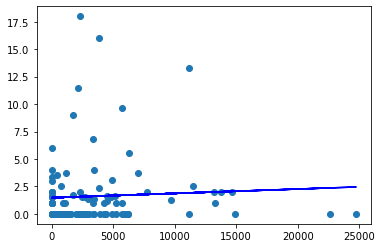

In [64]:
plt.scatter(x,y)
plt.plot(x,regr.predict(x), c='blue')
plt.show()

# x축=철새수
# y축=발생건수

In [78]:
print("A_value:",regr.intercept_) #세로축
print("B_value:",regr.coef_) #기울기

A_value: [1.47612993]
B_value: [[3.94318925e-05]]


In [73]:
residuals=AI_occur_local_m['평균발생건수']-AI_occur_local_m['평균예측발생건수']
residuals.describe()

count    112.000000
mean      -0.098125
std        3.149929
min       -4.800000
25%       -1.500000
50%       -1.200000
75%       -0.012500
max       16.400000
dtype: float64

In [102]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49373 missing from c

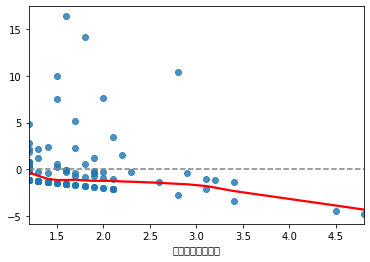

In [104]:
sns.regplot(AI_occur_local_m['평균예측발생건수'],residuals,lowess=True, line_kws={'color':'red'})
plt.plot([AI_occur_local_m['평균예측발생건수'].min(),AI_occur_local_m['평균예측발생건수'].max()],[0,0],'--',color='grey')

In [75]:
# SSE 오차제곱합
SSE=(residuals**2).sum()
SSE

1102.4263

In [79]:
# SST 총변동 (SSR+SSE)
SST=((AI_occur_local_m['평균발생건수']-AI_occur_local_m['평균발생건수'].mean())**2).sum()
SST

1080.2212276785715

In [81]:
# 결정계수
R_squared=1-(SSE/SST)
R_squared

-0.02055604144083345

In [ ]:
# linear 모델 불가 # 선형성이 없고, 상관관계도 없고, 비모수적이다.

In [99]:
# 분류모델 활용

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [106]:
AI_occur_local_m.head()

발생건수  시군구수  평균발생건수   평균철새수  평균예측발생건수  발생비율   순위  risk
시도  month                                                       
강원도 1       2.0   2.0     1.0  4259.0       1.8  0.56  7.0   3.5
    2       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    3       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    10      0.0   0.0     0.0  3031.0       1.7  0.00  6.0   3.0
    11      1.0   1.0     1.0  3381.0       1.7  0.59  6.0   3.0

In [116]:
train_data=AI_occur_local_m['평균철새수'].values
target_data=AI_occur_local_m['평균발생건수'].values

In [119]:
train_data[:10]

array([4259., 2801., 2801., 3031., 3381., 5241., 4931., 3820., 4500.,
          0.])

In [120]:
target_data[:10]

array([1.  , 0.  , 0.  , 0.  , 1.  , 1.  , 3.09, 2.33, 1.2 , 1.5 ])

In [124]:
# target_data one-hot-encoding
target_data2 = pd.get_dummies(list(target_data))

In [125]:
target_data2.head()

,0.00,1.00,1.20,1.25,1.33,1.50,1.67,1.75,2.00,2.33,...,4.00,5.57,6.00,6.83,9.00,9.64,11.50,13.25,16.00,18.00
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
train_x, test_x, train_y, test_y = train_test_split(train_data.reshape(-1,1), target_data2, test_size = 0.2, random_state = 42)

In [132]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_x,train_y)

RandomForestClassifier(random_state=42)

In [133]:
predict1 = clf.predict(test_x)
print(accuracy_score(test_y,predict1))

0.34782608695652173


In [ ]:
## 분류모델은 의미 없는 듯

In [134]:
from scipy import stats

In [138]:
train_data.sort()

In [139]:
target_data.sort()

In [141]:
stats.spearmanr(train_data,target_data) # 철새수와 발생건수는 강한 양의 상관관계가 성립한다.

SpearmanrResult(correlation=0.9301004266286962, pvalue=1.1590920367127312e-49)

In [84]:
temp

[(('강원도', 1),
  1    1
  6    1
  Name: 발생건수, dtype: int64),
 (('강원도', 11),
  3    1
  Name: 발생건수, dtype: int64),
 (('강원도', 12),
  2    1
  Name: 발생건수, dtype: int64),
 (('경기도', 1),
  12     1
  19     1
  21     1
  31     1
  35     1
  46     1
  48     1
  49     1
  55     1
  60     1
  61     1
  62     1
  64     1
  86     1
  100    1
  106    1
  108    1
  113    1
  118    1
  120    1
  131    1
  173    1
  200    1
  222    1
  237    1
  239    1
  246    1
  248    1
  249    1
  250    1
  252    1
  253    1
  263    1
  265    1
  Name: 발생건수, dtype: int64),
 (('경기도', 2),
  66     1
  71     1
  74     1
  78     1
  79     1
  102    1
  158    1
  Name: 발생건수, dtype: int64),
 (('경기도', 3),
  8      1
  43     1
  44     1
  107    1
  144    1
  194    1
  Name: 발생건수, dtype: int64),
 (('경기도', 4),
  11     1
  59     1
  140    1
  240    1
  244    1
  245    1
  Name: 발생건수, dtype: int64),
 (('경기도', 5),
  98    1
  99    1
  Name: 발생건수, dtype: int64),
 (('경기도', 6),
 

In [47]:
AI_occur_local_m.to_csv("철새수_다시_확인.csv", encoding='utf-8-sig')

In [ ]:
query('2014 < year < 2021')

In [8]:
#년-월-시도 발생일 카운트
AI_occur_local_ym=AI_occur_month.groupby(['year','month','시도'])['발생일'].count()
# 데이터프레임으로 변환
AI_occur_local_ym=AI_occur_local_ym.to_frame()
AI_occur_local_ym

발생일
year month 시도          
2003 12    경기도        2
           경상북도       4
           울산광역시      2
           전라남도       2
           충청남도       3
...                 ...
2021 2     제주특별자치도    1
           충청북도       4
     3     전라남도       4
           충청북도       2
     4     전라남도       2

[188 rows x 1 columns]

In [46]:
#철새 수 2014년 10,11,12만 2021년도는 1,2,3월만 있어 해당년도 삭제.
AI_occur_local_ym=AI_occur_month.query('2014 < year < 2021')
AI_occur_local_ym

,시도,datetime,주소,발생일,month,year
1,강원도,2017-01-03,강원도 인제군 기린면 북리,20170103,1,2017
2,강원도,2016-12-09,강원도 철원군 갈말읍 강포리,20161209,12,2016
3,강원도,2016-11-30,강원도 철원군 갈말읍 강포리,20161130,11,2016
6,강원도,2017-01-06,강원도 횡성군 횡성읍 학곡리,20170106,1,2017
8,경기도,2017-03-03,경기도 고양시 덕양구 관산동,20170303,3,2017
...,...,...,...,...,...,...
1114,충청북도,2016-12-12,충청북도 청주시 흥덕구 오송읍 동평리,20161212,12,2016
1115,충청북도,2016-12-01,충청북도 청주시 흥덕구 오송읍 동평리,20161201,12,2016
1116,충청북도,2016-11-29,충청북도 청주시 흥덕구 오송읍 쌍청리,20161129,11,2016
1117,충청북도,2016-12-04,충청북도 청주시 흥덕구 오송읍 오송리,20161204,12,2016


In [10]:
# 발생건수 열 만들기
month_local_br['발생건수']=np.nan
month_local_br.head()

,시도,시군구,year,month,철새수,발생건수
0,강원도,철원군,2014,10,51660,NaN
1,강원도,철원군,2014,11,43900,NaN
2,강원도,철원군,2014,12,9336,NaN
3,강원도,철원군,2015,1,10857,NaN
4,강원도,철원군,2015,2,14109,NaN


In [11]:
month=pd.DataFrame(columns=AI_occur_local_ym.columns)
month.head()

,시도,datetime,주소,발생일,month,year


In [12]:
AI_occur_local_ym.head()

,시도,datetime,주소,발생일,month,year
1,강원도,2017-01-03,강원도 인제군 기린면 북리,20170103,1,2017
2,강원도,2016-12-09,강원도 철원군 갈말읍 강포리,20161209,12,2016
3,강원도,2016-11-30,강원도 철원군 갈말읍 강포리,20161130,11,2016
6,강원도,2017-01-06,강원도 횡성군 횡성읍 학곡리,20170106,1,2017
8,경기도,2017-03-03,경기도 고양시 덕양구 관산동,20170303,3,2017


In [13]:
for n1, group in AI_occur_local_ym.groupby(['month']):
    group.reset_index(inplace=True, drop=True)
    if group.loc[0,'month'] in [1,2,3,10,11,12]:
        month=pd.concat([month, group])

In [42]:
month

,시도,datetime,주소,발생일,month,year,발생건수
0,강원도,2017-01-03,강원도 인제군 기린면 북리,20170103,1,2017,1
1,강원도,2017-01-06,강원도 횡성군 횡성읍 학곡리,20170106,1,2017,1
2,경기도,2015-01-19,경기도 광주시 오포읍 양벌리,20150119,1,2015,1
3,경기도,2015-01-31,경기도 김포시 통진읍 가현리,20150131,1,2015,1
4,경기도,2017-01-21,경기도 김포시 하성면 마조리,20170121,1,2017,1
...,...,...,...,...,...,...,...
290,충청북도,2016-12-10,충청북도 청주시 흥덕구 강내면 궁현리,20161210,12,2016,1
291,충청북도,2016-12-12,충청북도 청주시 흥덕구 오송읍 동평리,20161212,12,2016,1
292,충청북도,2016-12-01,충청북도 청주시 흥덕구 오송읍 동평리,20161201,12,2016,1
293,충청북도,2016-12-04,충청북도 청주시 흥덕구 오송읍 오송리,20161204,12,2016,1


In [43]:
month['발생건수']=1
month

,시도,datetime,주소,발생일,month,year,발생건수
0,강원도,2017-01-03,강원도 인제군 기린면 북리,20170103,1,2017,1
1,강원도,2017-01-06,강원도 횡성군 횡성읍 학곡리,20170106,1,2017,1
2,경기도,2015-01-19,경기도 광주시 오포읍 양벌리,20150119,1,2015,1
3,경기도,2015-01-31,경기도 김포시 통진읍 가현리,20150131,1,2015,1
4,경기도,2017-01-21,경기도 김포시 하성면 마조리,20170121,1,2017,1
...,...,...,...,...,...,...,...
290,충청북도,2016-12-10,충청북도 청주시 흥덕구 강내면 궁현리,20161210,12,2016,1
291,충청북도,2016-12-12,충청북도 청주시 흥덕구 오송읍 동평리,20161212,12,2016,1
292,충청북도,2016-12-01,충청북도 청주시 흥덕구 오송읍 동평리,20161201,12,2016,1
293,충청북도,2016-12-04,충청북도 청주시 흥덕구 오송읍 오송리,20161204,12,2016,1


In [44]:
# 년-월 발생건수
B=month.groupby(['year','month']).sum()
B

발생건수
year month      
2015 1        38
     2        35
     3        29
     10        7
     11        3
2016 3         1
     11       66
     12      247
2017 1        29
     2        13
     3        29
     11        1
     12        7
2018 1         8
     2         2
     3         4
2020 11        2
     12       41

In [16]:
#발생건수 합쳐주기.
A=month_local_br.groupby(['year','month']).sum()
print(A)
A['발생건수']=B
#A.loc[2019,'발생건수']=np.round((A.loc[2018,'발생건수']+A.loc[2020,'발생건수'])/2,0)
A=A.fillna(0)
A

                철새수  발생건수
year month               
2014 10      658519   0.0
     11     1138090   0.0
     12     1230756   0.0
2015 1      1072942   0.0
     2       777717   0.0
     3      1212369   0.0
     10      529192   0.0
     11      870346   0.0
     12     1944040   0.0
2016 1      1742589   0.0
     2      1029590   0.0
     3       515353   0.0
     10      542767   0.0
     11      982244   0.0
     12     1343073   0.0
2017 1      1489334   0.0
     2       996360   0.0
     3       483984   0.0
     10      391838   0.0
     11      627030   0.0
     12     1202766   0.0
2018 1      1579306   0.0
     2      1093577   0.0
     3       426978   0.0
     10      461740   0.0
     11      780281   0.0
     12     1461500   0.0
2019 1      1619361   0.0
     2       737360   0.0
     3       398783   0.0
     10      616639   0.0
     11      725090   0.0
     12     1999044   0.0
2020 1      1837770   0.0
     2       947178   0.0
     3       398955   0.0
     10     

철새수   발생건수
year month                
2014 10      658519    0.0
     11     1138090    0.0
     12     1230756    0.0
2015 1      1072942   38.0
     2       777717   35.0
     3      1212369   29.0
     10      529192    7.0
     11      870346    3.0
     12     1944040    0.0
2016 1      1742589    0.0
     2      1029590    0.0
     3       515353    1.0
     10      542767    0.0
     11      982244   66.0
     12     1343073  247.0
2017 1      1489334   29.0
     2       996360   13.0
     3       483984   29.0
     10      391838    0.0
     11      627030    1.0
     12     1202766    7.0
2018 1      1579306    8.0
     2      1093577    2.0
     3       426978    4.0
     10      461740    0.0
     11      780281    0.0
     12     1461500    0.0
2019 1      1619361    0.0
     2       737360    0.0
     3       398783    0.0
     10      616639    0.0
     11      725090    0.0
     12     1999044    0.0
2020 1      1837770    0.0
     2       947178    0.0
     3       398955    0.0
     10      583945    0.0
     11     1032392    2.0
     12     1731813   41.0
2021 1      1651278    0.0
     2      1003800    0.0
     3       554019    0.0

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
A

철새수   발생건수
year month                
2014 10      658519    0.0
     11     1138090    0.0
     12     1230756    0.0
2015 1      1072942   38.0
     2       777717   35.0
     3      1212369   29.0
     10      529192    7.0
     11      870346    3.0
     12     1944040    0.0
2016 1      1742589    0.0
     2      1029590    0.0
     3       515353    1.0
     10      542767    0.0
     11      982244   66.0
     12     1343073  247.0
2017 1      1489334   29.0
     2       996360   13.0
     3       483984   29.0
     10      391838    0.0
     11      627030    1.0
     12     1202766    7.0
2018 1      1579306    8.0
     2      1093577    2.0
     3       426978    4.0
     10      461740    0.0
     11      780281    0.0
     12     1461500    0.0
2019 1      1619361    0.0
     2       737360    0.0
     3       398783    0.0
     10      616639    0.0
     11      725090    0.0
     12     1999044    0.0
2020 1      1837770    0.0
     2       947178    0.0
     3       398955    0.0
     10      583945    0.0
     11     1032392    2.0
     12     1731813   41.0
2021 1      1651278    0.0
     2      1003800    0.0
     3       554019    0.0

In [18]:
A.describe()

,철새수,발생건수
count,4.200000e+01,42.000000
mean,1.010041e+06,13.380952
std,4.747616e+05,39.842343
min,3.918380e+05,0.000000
25%,5.921185e+05,0.000000
50%,9.893020e+05,0.000000
75%,1.314994e+06,7.000000
max,1.999044e+06,247.000000


In [19]:
def get_outlier(df=None, column=None, weight=1.5):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [20]:
outlier_idx = get_outlier(df=A, column='철새수', weight=1.5)
A.drop(outlier_idx, axis=0, inplace=True)

In [21]:
A

철새수   발생건수
year month                
2014 10      658519    0.0
     11     1138090    0.0
     12     1230756    0.0
2015 1      1072942   38.0
     2       777717   35.0
     3      1212369   29.0
     10      529192    7.0
     11      870346    3.0
     12     1944040    0.0
2016 1      1742589    0.0
     2      1029590    0.0
     3       515353    1.0
     10      542767    0.0
     11      982244   66.0
     12     1343073  247.0
2017 1      1489334   29.0
     2       996360   13.0
     3       483984   29.0
     10      391838    0.0
     11      627030    1.0
     12     1202766    7.0
2018 1      1579306    8.0
     2      1093577    2.0
     3       426978    4.0
     10      461740    0.0
     11      780281    0.0
     12     1461500    0.0
2019 1      1619361    0.0
     2       737360    0.0
     3       398783    0.0
     10      616639    0.0
     11      725090    0.0
     12     1999044    0.0
2020 1      1837770    0.0
     2       947178    0.0
     3       398955    0.0
     10      583945    0.0
     11     1032392    2.0
     12     1731813   41.0
2021 1      1651278    0.0
     2      1003800    0.0
     3       554019    0.0

In [22]:
A=A.query('2014 < year < 2021')
A.head()

철새수  발생건수
year month               
2015 1      1072942  38.0
     2       777717  35.0
     3      1212369  29.0
     10      529192   7.0
     11      870346   3.0

In [23]:
x=np.reshape(A['철새수'].values, ((1,)+A['발생건수'].values.shape))

In [24]:
x=np.expand_dims(A['철새수'].values, axis=1)

In [25]:
x

array([[1072942],
       [ 777717],
       [1212369],
       [ 529192],
       [ 870346],
       [1944040],
       [1742589],
       [1029590],
       [ 515353],
       [ 542767],
       [ 982244],
       [1343073],
       [1489334],
       [ 996360],
       [ 483984],
       [ 391838],
       [ 627030],
       [1202766],
       [1579306],
       [1093577],
       [ 426978],
       [ 461740],
       [ 780281],
       [1461500],
       [1619361],
       [ 737360],
       [ 398783],
       [ 616639],
       [ 725090],
       [1999044],
       [1837770],
       [ 947178],
       [ 398955],
       [ 583945],
       [1032392],
       [1731813]], dtype=int64)

In [26]:
y=A['발생건수'].values
y

array([ 38.,  35.,  29.,   7.,   3.,   0.,   0.,   0.,   1.,   0.,  66.,
       247.,  29.,  13.,  29.,   0.,   1.,   7.,   8.,   2.,   4.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   2.,  41.])

In [27]:
D78=pd.read_csv("brids_risktable.csv")
print(D78.head())
C=D78['철새수']
C

   month     시도  발생건수(타겟)      철새수  range   result 철새수/result  표준 risk  risk  \
0      1    강원도         2   626130    2,3   947733        66%        5     3   
1      1    경기도        55  1242626  55,56  1072138       116%        5     5   
2      1   경상남도        11   347682  11,12   968858        36%        5     1   
3      1   경상북도         2   554884    2,3   947733        59%        5     2   
4      1  광주광역시         0    49915    0,1   943038         5%        5     0   

   Unnamed: 9 리스크 기준(이상/미만)   점수  
0         NaN        0%~20%  0.0  
1         NaN       20%~40%  1.0  
2         NaN       40%~60%  2.0  
3         NaN       60%~80%  3.0  
4         NaN      80%~100%  4.0  


0       626130
1      1242626
2       347682
3       554884
4        49915
        ...   
113    2099384
114     965887
115     213369
116    2737777
117     212265
Name: 철새수, Length: 118, dtype: int64

In [43]:
from statsmodels.formula.api import ols
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
regr=linear_model.LinearRegression()
regr.fit(x, y)

LinearRegression()

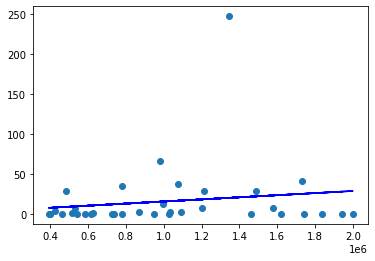

In [29]:
plt.scatter(x,y)
plt.plot(x,regr.predict(x), c='blue')
plt.show()

# x축=철새수
# y축=발생건수

In [30]:
result=[]
#num=C
for i in C:
    result.append(np.round(regr.predict([[i]]),0))

In [31]:
result

[array([11.]),
 array([19.]),
 array([7.]),
 array([10.]),
 array([3.]),
 array([3.]),
 array([8.]),
 array([4.]),
 array([3.]),
 array([12.]),
 array([5.]),
 array([16.]),
 array([26.]),
 array([6.]),
 array([47.]),
 array([5.]),
 array([8.]),
 array([15.]),
 array([4.]),
 array([7.]),
 array([3.]),
 array([2.]),
 array([7.]),
 array([3.]),
 array([3.]),
 array([7.]),
 array([3.]),
 array([9.]),
 array([12.]),
 array([4.]),
 array([34.]),
 array([4.]),
 array([8.]),
 array([17.]),
 array([3.]),
 array([5.]),
 array([3.]),
 array([2.]),
 array([5.]),
 array([4.]),
 array([3.]),
 array([4.]),
 array([2.]),
 array([5.]),
 array([5.]),
 array([3.]),
 array([18.]),
 array([4.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([

In [32]:
R=result
R

[array([11.]),
 array([19.]),
 array([7.]),
 array([10.]),
 array([3.]),
 array([3.]),
 array([8.]),
 array([4.]),
 array([3.]),
 array([12.]),
 array([5.]),
 array([16.]),
 array([26.]),
 array([6.]),
 array([47.]),
 array([5.]),
 array([8.]),
 array([15.]),
 array([4.]),
 array([7.]),
 array([3.]),
 array([2.]),
 array([7.]),
 array([3.]),
 array([3.]),
 array([7.]),
 array([3.]),
 array([9.]),
 array([12.]),
 array([4.]),
 array([34.]),
 array([4.]),
 array([8.]),
 array([17.]),
 array([3.]),
 array([5.]),
 array([3.]),
 array([2.]),
 array([5.]),
 array([4.]),
 array([3.]),
 array([4.]),
 array([2.]),
 array([5.]),
 array([5.]),
 array([3.]),
 array([18.]),
 array([4.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([

In [33]:
print(regr.coef_, regr.intercept_)

[1.31015594e-05] 2.4421347520418344


In [34]:
df897.to_csv("birds_risk_table2.csv", encoding='utf-8-sig')

NameError: name 'df897' is not defined